plot chromHMM

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
## for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"


In [7]:
# for GM12878
GM_name_dict = {"E1":"Polycomb repressed",
                "E2":"Quiescence",
                "E3":"Heterochromatin",
                "E4":"Weak Tx",
                "E5":"Tx elongation",
                "E6":"Weak enhancer",
                "E7":"Active enhancer",
                "E8":"Strong enhancer",
                "E9":"Active promoter",
                "E10":"Weak promoter",
                "E11":"Poised promoter",
                "E12":"Insulator"}

# state for GM
GM_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Active enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence"]

GM_HMM_fname = "GM12878_12_segments.bed"


In [8]:
# for mouse CD8 T cell
mCD8T_name_dict = {"E1":"Weak Tx",
                   "E2":"Tx elongation",
                   "E3":"Weak enhancer2",
                   "E4":"Strong enhancer2",
                   "E5":"Strong enhancer1",
                   "E6":"Weak enhancer1",
                   "E7":"Active promoter",
                   "E8":"Poised promoter",
                   "E9":"Polycomb repressed1",
                   "E10":"Polycomb repressed2",
                   "E11":"Quiescence",
                   "E12":"Heterochromatin"}

# state for mouse CD8 T cell
mCD8T_states = ["Active promoter", "Poised promoter", "Strong enhancer1", "Strong enhancer2", "Weak enhancer1", "Weak enhancer2", "Tx elongation", "Weak Tx", "Polycomb repressed1", "Polycomb repressed2", "Heterochromatin", "Quiescence"]

mCD8T_HMM_fname = "Mouse CD8 T cell (invitro activated)_12_segments.bed"


In [9]:
# data path
#path = './data/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

In [10]:
# chromHMM data set
cell_chromHMM = {'H1':[H1_HMM_fname, H1_name_dict, H1_states],
                 'GM':[GM_HMM_fname, GM_name_dict, GM_states],
                 'mCD8T':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states]}


In [11]:
### set target cell
cell = 'mCD8T'

In [12]:
### set target chromosomes
chr_choices = cell_chrnames['mCD8T:WT']
#chr_choices = ['chr1']

In [13]:
### load gtab file
gtab_path = '/Users/sangwoopark/jhu_rockfish/ODC_mouse_HistoneChip/'

dinfo_dkey = {'H3K27ac_Ctrl_1rep_count.gtab.gz':
              {'ChIP_Ctrl_H3k27ac_mm10_final':(1, 'mCD8T:WT', 'H3K27ac')},
              'H3K27ac_Ctrl_2rep_count.gtab.gz':
              {'H3k27ac_Ctrl_3_mm10_final':(2, 'mCD8T:WT', 'H3K27ac')},
              'H3K27ac_Ctrl_3rep_count.gtab.gz':
              {'H3k27ac_Ctrl_4_mm10_final':(3, 'mCD8T:WT', 'H3K27ac')},
              'H3K27me3_Ctrl_1rep_count.gtab.gz':
              {'ChIP_Ctrl_H3k27ac_mm10_final':(1, 'mCD8T:WT', 'H3K27me3')},
              'H3K27me3_Ctrl_2rep_count.gtab.gz':
              {'H3k27ac_Ctrl_3_mm10_final':(2, 'mCD8T:WT', 'H3K27me3')},
              'H3K27me3_Ctrl_3rep_count.gtab.gz':
              {'H3k27ac_Ctrl_4_mm10_final':(3, 'mCD8T:WT', 'H3K27me3')},
              'H3K27ac_Treat_1rep_count.gtab.gz':
              {'ChIP_Treat_H3k27ac_mm10_final':(1, 'mCD8T:DFMO', 'H3K27ac')},
              'H3K27ac_Treat_2rep_count.gtab.gz':
              {'H3k27ac_Treat_3_mm10_final':(2, 'mCD8T:DFMO', 'H3K27ac')},
              'H3K27ac_Treat_3rep_count.gtab.gz':
              {'H3k27ac_Treat_4_mm10_final':(3, 'mCD8T:DFMO', 'H3K27ac')},
              'H3K27me3_Treat_1rep_count.gtab.gz':
              {'ChIP_Treat_H3k27ac_mm10_final':(1, 'mCD8T:DFMO', 'H3K27me3')},
              'H3K27me3_Treat_2rep_count.gtab.gz':
              {'H3k27ac_Treat_3_mm10_final':(2, 'mCD8T:DFMO', 'H3K27me3')},
              'H3K27me3_Treat_3rep_count.gtab.gz':
              {'H3k27ac_Treat_4_mm10_final':(3, 'mCD8T:DFMO', 'H3K27me3')}}

dkey_chr_ID_value = load_file.read_gtab_batch(dinfo_dkey,
                                              data_path=gtab_path,
                                              chr_choices=chr_choices,
                                              by_chr=True)

loading H3K27ac_Ctrl_1rep_count.gtab.gz


loading H3K27me3_Treat_2rep_count.gtab.gz


loading H3K27ac_Treat_1rep_count.gtab.gz


loading H3K27ac_Ctrl_2rep_count.gtab.gz


loading H3K27me3_Treat_3rep_count.gtab.gz


loading H3K27me3_Ctrl_3rep_count.gtab.gz


loading H3K27ac_Ctrl_3rep_count.gtab.gz


loading H3K27ac_Treat_2rep_count.gtab.gz


loading H3K27ac_Treat_3rep_count.gtab.gz


loading H3K27me3_Ctrl_1rep_count.gtab.gz


loading H3K27me3_Ctrl_2rep_count.gtab.gz


loading H3K27me3_Treat_1rep_count.gtab.gz


Done


In [14]:
### convert the normalized read-count to log2 (1+read-count)
for dkey in dkey_chr_ID_value:
    for chr in dkey_chr_ID_value[dkey]:
        for ID in dkey_chr_ID_value[dkey][chr]:
            value = dkey_chr_ID_value[dkey][chr][ID]
            dkey_chr_ID_value[dkey][chr][ID] = np.log2(1.0 + value)

In [33]:
print dkey_chr_ID_value[(1, 'mCD8T:DFMO', 'H3K27ac')]['chr1'].values()[:10]

[0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 0.9480475837363962, 1.5152734312981182, 0.9480475837363962]


In [15]:
### loading the chromHMM data
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

HMM_fname, name_dict, states = cell_chromHMM[cell]
chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                              state_name=name_dict,
                                              chr_choices=chr_choices)

In [16]:
### make chromHMM interval dictionary
chr_state_dict = {}
for chr in chr_choices:
    state_intervals = chr_state_intervals[chr]
    dID_interval = {}
    for state in state_intervals:        
        intervals = state_intervals[state]
        for i in range(len(intervals)):
            dID = state + ':' + str(i)
            assert dID not in dID_interval
            dID_interval[dID] = intervals[i]

    state_dict = Interval_dict.double_hash(dID_interval)
    chr_state_dict[chr] = state_dict

hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


hash fucntion is built


In [17]:
### categorize by chromHMM
dkey_state_IDs = {}
for dkey in dkey_chr_ID_value:
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_IDs = {}
    for chr in chr_ID_value:
        try:
            ID_pos = {ID:ID[1] for ID in chr_ID_value[chr]}        
            state_IDs_temp = statis.categorize(chr_state_intervals[chr],
                                               ID_pos,
                                               hash_func=chr_state_dict[chr])
        except:
            ID_interval = {ID:(ID[1], ID[2]) for ID in chr_ID_value[chr]}        
            state_IDs_temp = statis.categorize_bin(chr_state_intervals[chr],
                                                   ID_interval,
                                                   hash_func=chr_state_dict[chr])

        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
    dkey_state_IDs[dkey] = state_IDs
    

In [18]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_state_IDs:    
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values

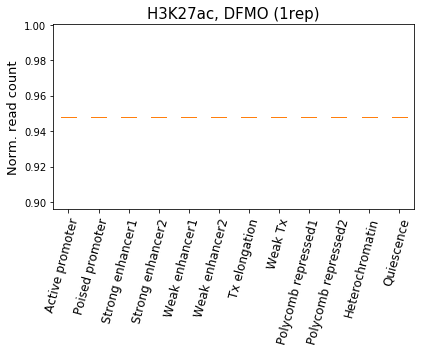

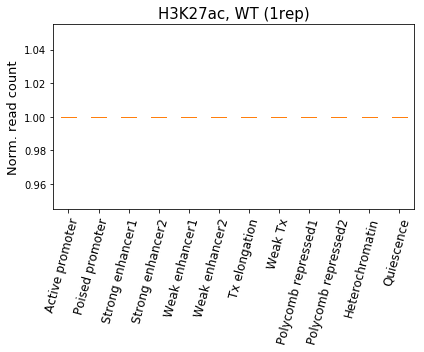

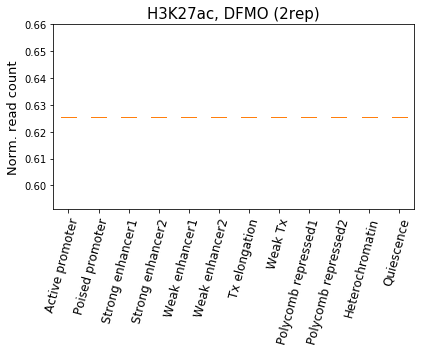

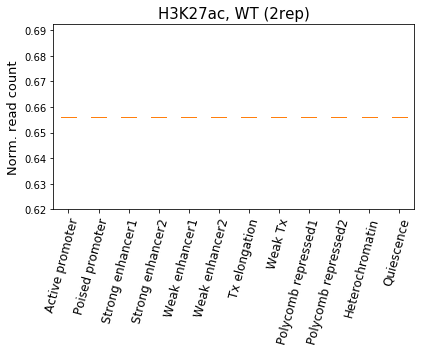

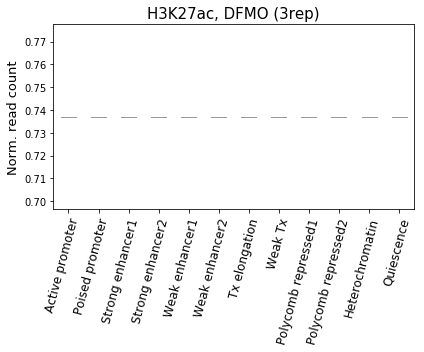

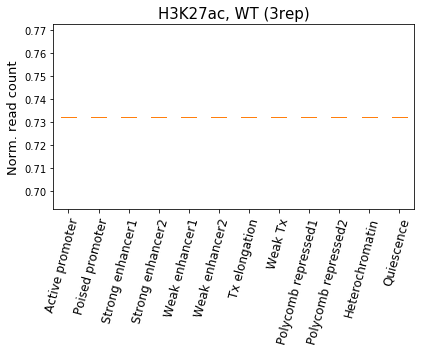

In [19]:
### plot the chromHMM (single)
for dkey in sorted(dkey_state_values):
    state_values = dkey_state_values[dkey]

    graphics.plot_boxplot (state_values,
                           keys = states,
                           fig_width=6,
                           fig_height=5,
                           ylabel='Norm. read count',
                           title='%s, %s (%drep)' % (dkey[2], dkey[1].split(':')[1], dkey[0]),
                           rotation=75,
                           note='%s, %s (%drep)' % (dkey[2], dkey[1].split(':')[1], dkey[0]),
                           save=False)
    print
    

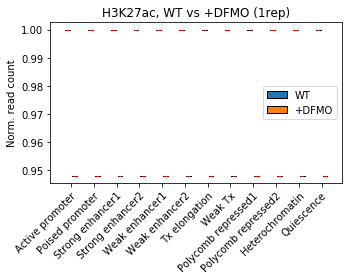

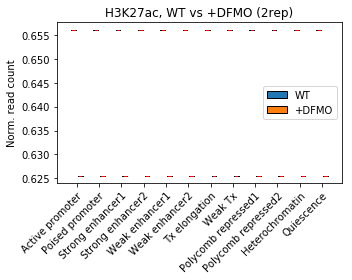

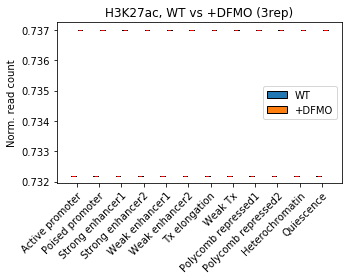

KeyError: (1, 'mCD8T:WT', 'H3K27me3')

In [20]:
### plot chromHMM (WT vs DFMO)
marks = ['H3K27ac', 'H3K27me3']
reps = [1, 2, 3]
for mark in marks:
    for rep in reps:
        graphics.plot_boxplot_multiple ([dkey_state_values[(rep, 'mCD8T:WT', mark)],
                                         dkey_state_values[(rep, 'mCD8T:DFMO', mark)]],
                                        keys=states,
                                        ylabel='Norm. read count',
                                        title='%s, WT vs +DFMO (%drep)' % (mark, rep),
                                        rotation=45,
                                        colors=['tab:blue',
                                                'tab:orange'],
                                        labels=['WT',
                                                '+DFMO'],
                                        legend_loc='best',
                                        save_path='./data/',
                                        save=True,
                                        note='%s_WTvs+DFMO_%drep' % (mark, rep))
        print

In [21]:
### merge replicates
cells = ['mCD8T:WT', 'mCD8T:DFMO']
marks = ['H3K27ac', 'H3K27me3']
reps = [1, 2, 3]
for cell in cells:
    for mark in marks:
        state_values = {}
        for rep in reps:
            for state, values in dkey_state_values[(rep, cell, mark)].items():
                if state not in state_values:
                    state_values[state] = []
                state_values[state] += values
        dkey_state_values[('merge', cell, mark)] = state_values

KeyError: (1, 'mCD8T:WT', 'H3K27me3')

In [22]:
### plot chromHMM (WT vs DFMO, merged data)
marks = ['H3K27ac', 'H3K27me3']
for mark in marks:
    graphics.plot_boxplot_multiple ([dkey_state_values[('merge', 'mCD8T:WT', mark)],
                                     dkey_state_values[('merge', 'mCD8T:DFMO', mark)]],
                                    keys=states,
                                    ylabel='Norm. read count',
                                    title='%s, WT vs +DFMO' % (mark),
                                    rotation=45,
                                    fig_width=5,
                                    fig_height=3,
                                    colors=['tab:blue',
                                            'tab:orange'],
                                    labels=['WT',
                                            '+DFMO'],
                                    legend_loc='best',
                                    save_path='./data/',
                                    save=True,
                                    note='%s_WTvs+DFMO' % (mark))
    print

KeyError: ('merge', 'mCD8T:DFMO', 'H3K27ac')

In [23]:
### compute statistical significance (H3K27ac, merged data)
dkey1 = ('merge', 'mCD8T:WT', 'H3K27ac')
dkey2 = ('merge', 'mCD8T:DFMO', 'H3K27ac')

for state in states:
    print state
    values1 = dkey_state_values[dkey1][state]
    values2 = dkey_state_values[dkey2][state]
    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
    CohenD = statis.get_CohenD (values1, values2)
    print CohenD
    print pvalue
    print

Active promoter


KeyError: ('merge', 'mCD8T:DFMO', 'H3K27ac')

In [24]:
### compute statistical significance (H3K27me3, merged data)
dkey1 = ('merge', 'mCD8T:WT', 'H3K27me3')
dkey2 = ('merge', 'mCD8T:DFMO', 'H3K27me3')

for state in states:
    print state
    values1 = dkey_state_values[dkey1][state]
    values2 = dkey_state_values[dkey2][state]
    pvalue = stats.ttest_ind(values1, values2, equal_var=False)[1]
    CohenD = statis.get_CohenD (values1, values2)
    print CohenD
    print pvalue
    print

Active promoter


KeyError: ('merge', 'mCD8T:WT', 'H3K27me3')